In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_error
import lmfit
from tqdm.auto import tqdm
import pickle
import joblib
import matplotlib.dates as mdates

sns.set()
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_context("talk")
sns.set_style("ticks")

# Preprocessing Data

In [2]:
df = pd.read_csv('data/all.csv', index_col = 0, parse_dates = True)
df

,case_by_day,case_by_time,active_by_day,active_by_time,death_by_day,death_by_time,recovered_by_day,recovered_by_time
2021-01-01,9,1474,NaN,NaN,0,35,0,1325
2021-01-02,8,1482,NaN,NaN,0,35,12,1337
2021-01-03,12,1494,NaN,NaN,0,35,2,1339
2021-01-04,3,1497,NaN,NaN,0,35,0,1339
2021-01-05,7,1504,NaN,NaN,0,35,0,1339
...,...,...,...,...,...,...,...,...
2022-03-27,91916,9011473,-93993.0,3617189.0,48,42306,185861,5351978
2022-03-28,263376,9274849,140594.0,3757783.0,52,42358,122730,5474708
2022-03-29,111640,9386489,-1567553.0,2190230.0,55,42413,1679138,7153846
2022-03-30,85765,9472254,-28961.0,2161269.0,41,42454,114685,7268531


In [3]:
df = df[['case_by_time', 'recovered_by_time', 'death_by_time',
         'death_by_day', 'case_by_day', 'recovered_by_day']]
df.columns = ['total_infected', 'total_recovered', 'total_dead', 'deaths_per_day', 'infected_per_day', 'recovered_per_day']
df.head()

,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day
2021-01-01,1474,1325,35,0,9,0
2021-01-02,1482,1337,35,0,8,12
2021-01-03,1494,1339,35,0,12,2
2021-01-04,1497,1339,35,0,3,0
2021-01-05,1504,1339,35,0,7,0


In [4]:
df.describe()

,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day
count,4.550000e+02,4.550000e+02,455.000000,455.000000,455.000000,4.550000e+02
mean,1.057132e+06,7.478460e+05,14102.316484,91.334066,20996.764835,1.652413e+04
std,1.810467e+06,1.162089e+06,15578.085134,120.773345,54545.269918,8.458137e+04
min,1.474000e+03,1.325000e+03,35.000000,-382.000000,0.000000,0.000000e+00
25%,2.838000e+03,2.516000e+03,35.000000,0.000000,19.500000,7.500000e+00
50%,2.836960e+05,1.069770e+05,6141.000000,56.000000,5376.000000,1.347000e+03
75%,1.344822e+06,1.024024e+06,26815.000000,163.000000,14338.000000,1.055900e+04
max,9.564609e+06,7.519013e+06,42493.000000,804.000000,454212.000000,1.679138e+06


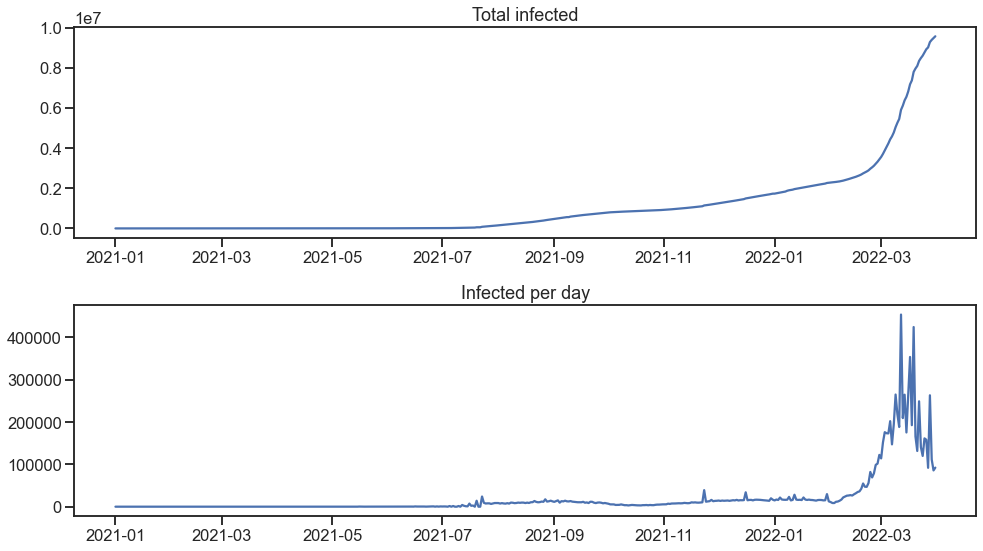

In [5]:
fig = plt.figure(figsize=(14,8))
ax1 = plt.subplot(2, 1, 1)

plt.plot(df.index, df.total_infected.values)
plt.title("Total infected")
plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(df.index, df.infected_per_day.values)
plt.title("Infected per day")
plt.tight_layout()
plt.show()

In [6]:
df_smoothed = df.rolling(7).mean().round(5)
df_smoothed.columns = [col + '_ma7' for col in df_smoothed.columns]

full_df = pd.concat([df, df_smoothed], axis=1)

for column in full_df.columns:
    if column.endswith('_ma7'):
        original_column = column.strip('_ma7')
        full_df[column] = full_df[column].fillna(full_df[original_column])
df = full_df
df = df.reset_index()
df.columns = ['date', 'total_infected', 'total_recovered', 'total_dead', 'deaths_per_day', 'infected_per_day', 'recovered_per_day', 'total_infected_ma7', 'total_recovered_ma7', 'total_dead_ma7', 'deaths_per_day_ma7', 'infected_per_day_ma7', 'recovered_per_day_ma7']
df

,date,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,total_infected_ma7,total_recovered_ma7,total_dead_ma7,deaths_per_day_ma7,infected_per_day_ma7,recovered_per_day_ma7
0,2021-01-01,1474,1325,35,0,9,0,1.474000e+03,1.325000e+03,35.00000,0.00000,9.00000,0.00000
1,2021-01-02,1482,1337,35,0,8,12,1.482000e+03,1.337000e+03,35.00000,0.00000,8.00000,12.00000
2,2021-01-03,1494,1339,35,0,12,2,1.494000e+03,1.339000e+03,35.00000,0.00000,12.00000,2.00000
3,2021-01-04,1497,1339,35,0,3,0,1.497000e+03,1.339000e+03,35.00000,0.00000,3.00000,0.00000
4,2021-01-05,1504,1339,35,0,7,0,1.504000e+03,1.339000e+03,35.00000,0.00000,7.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,2022-03-27,9011473,5351978,42306,48,91916,185861,8.600066e+06,4.822632e+06,42134.71429,60.85714,150489.28571,178421.42857
451,2022-03-28,9274849,5474708,42358,52,263376,122730,8.769364e+06,4.992924e+06,42193.14286,58.42857,169298.28571,170291.42857
452,2022-03-29,9386489,7153846,42413,55,111640,1679138,8.919017e+06,5.376501e+06,42250.14286,57.00000,149653.57143,383577.28571
453,2022-03-30,9472254,7268531,42454,41,85765,114685,9.060804e+06,5.748967e+06,42304.28571,54.14286,141786.14286,372465.85714


In [24]:
train_subset = df[df['date'] <= '2021-11-30']
# train_subset = df[df['date'] <= '2021-02-28']
test_subset = df[df['date'] > '2021-11-30']
train_subset

,date,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,total_infected_ma7,total_recovered_ma7,total_dead_ma7,deaths_per_day_ma7,infected_per_day_ma7,recovered_per_day_ma7
0,2021-01-01,1474,1325,35,0,9,0,1.474000e+03,1325.00000,35.00000,0.00000,9.00000,0.00000
1,2021-01-02,1482,1337,35,0,8,12,1.482000e+03,1337.00000,35.00000,0.00000,8.00000,12.00000
2,2021-01-03,1494,1339,35,0,12,2,1.494000e+03,1339.00000,35.00000,0.00000,12.00000,2.00000
3,2021-01-04,1497,1339,35,0,3,0,1.497000e+03,1339.00000,35.00000,0.00000,3.00000,0.00000
4,2021-01-05,1504,1339,35,0,7,0,1.504000e+03,1339.00000,35.00000,0.00000,7.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,2021-11-26,1181337,955256,24544,137,13109,12368,1.133326e+06,923261.14286,24101.28571,138.00000,15177.57143,10241.71429
330,2021-11-27,1197404,956924,24692,148,16067,1668,1.149438e+06,931345.00000,24245.14286,143.85714,16111.28571,8083.85714
331,2021-11-28,1210340,958636,24882,190,12936,1712,1.165984e+06,938935.85714,24405.28571,160.14286,16546.57143,7590.85714
332,2021-11-29,1224110,974724,25055,173,13770,16088,1.183023e+06,948142.71429,24563.00000,157.71429,17039.28571,9206.85714


# Classic SEIRD

In [8]:
class BarebonesSEIR:
    def __init__(self, params=None):
        self.params = params

    def get_fit_params(self):
        params = lmfit.Parameters()
        params.add("population", value=12_000_000, vary=False)
        params.add("epidemic_started_days_ago", value=10, vary=False)
        params.add("r0", value=4, min=3, max=5, vary=True)
        params.add("alpha", value=0.0064, min=0.005, max=0.0078, vary=True)  # CFR
        params.add("delta", value=1/3, min=1/14, max=1/2, vary=True)  # E -> I rate
        params.add("gamma", value=1/9, min=1/14, max=1/7, vary=True)  # I -> R rate
        params.add("rho", expr='gamma', vary=False)  # I -> D rate
        return params

    def get_initial_conditions(self, data):
        # Simulate such initial params as to obtain as many deaths as in data
        population = self.params['population']
        epidemic_started_days_ago = self.params['epidemic_started_days_ago']

        t = np.arange(epidemic_started_days_ago)
        (S, E, I, R, D) = self.predict(t, (population - 1, 0, 1, 0, 0))

        I0 = I[-1]
        E0 = E[-1]
        Rec0 = R[-1]
        D0 = D[-1]
        S0 = S[-1]
        return (S0, E0, I0, Rec0, D0)

    def step(self, initial_conditions, t):
        population = self.params['population']
        delta = self.params['delta']
        gamma = self.params['gamma']
        alpha = self.params['alpha']
        rho = self.params['rho']
        
        rt = self.params['r0'].value
        beta = rt * gamma

        S, E, I, R, D = initial_conditions

        new_exposed = beta * I * (S / population)
        new_infected = delta * E
        new_dead = alpha * rho * I
        new_recovered = gamma * (1 - alpha) * I

        dSdt = -new_exposed
        dEdt = new_exposed - new_infected
        dIdt = new_infected - new_recovered - new_dead
        dRdt = new_recovered
        dDdt = new_dead

        assert S + E + I + R + D - population <= 1e10
        assert dSdt + dIdt + dEdt + dRdt + dDdt <= 1e10
        return dSdt, dEdt, dIdt, dRdt, dDdt

    def predict(self, t_range, initial_conditions):
        ret = odeint(self.step, initial_conditions, t_range)
        return ret.T

In [9]:
model = BarebonesSEIR()
model.params = model.get_fit_params()
train_initial_conditions = model.get_initial_conditions(train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, R, D) = model.predict(train_t, train_initial_conditions)

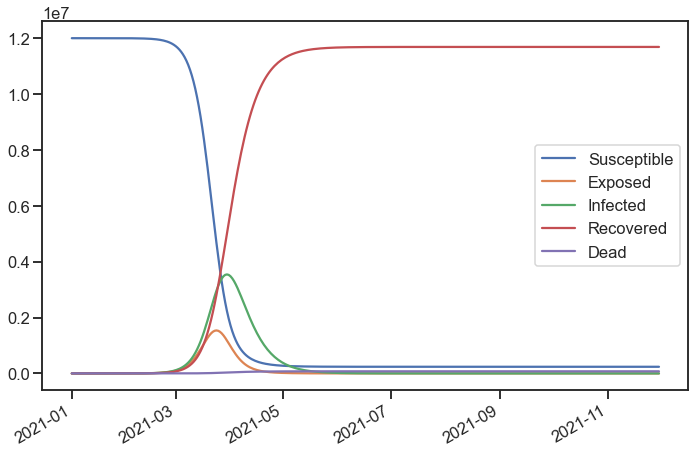

In [10]:
fig = plt.figure(figsize=(10,7))
plt.plot(train_subset.date, S, label='Susceptible')
plt.plot(train_subset.date, E, label='Exposed')
plt.plot(train_subset.date, I, label='Infected')
plt.plot(train_subset.date, R, label='Recovered')
plt.plot(train_subset.date, D, label='Dead')
plt.legend()
plt.tight_layout()
fig.autofmt_xdate()
plt.show()

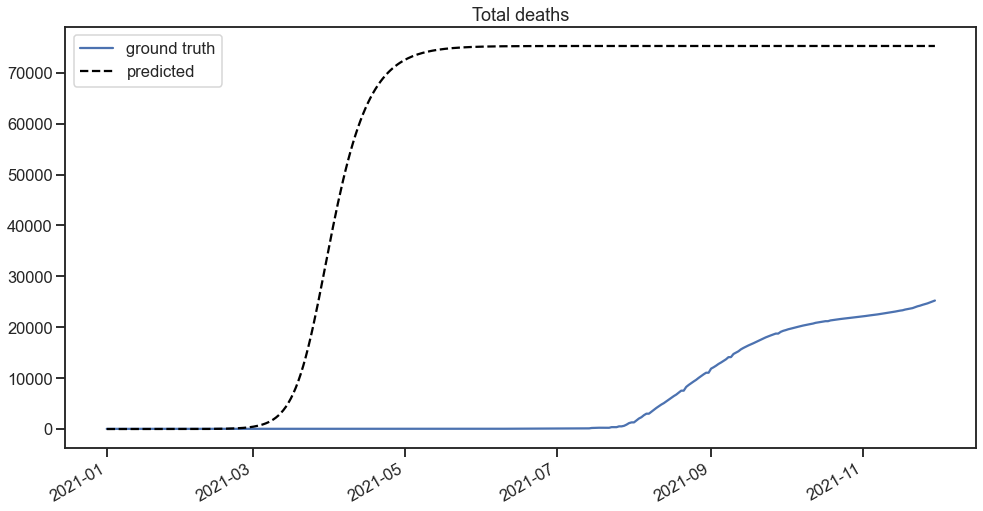

In [11]:
fig = plt.figure(figsize=(14, 8))
plt.plot(train_subset.date, train_subset['total_dead'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted', color='black', linestyle='dashed' )
plt.legend()
plt.title('Total deaths')
plt.tight_layout()
fig.autofmt_xdate()
plt.show()

# Quarantine measures

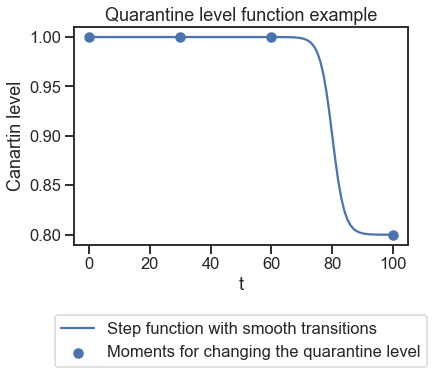

In [12]:
def sigmoid(x, xmin, xmax, a, b, c, r):
    x_scaled = (x - xmin) / (xmax - xmin)
    out = (a * np.exp(c * r) + b * np.exp(r * x_scaled)) / (np.exp(c * r) + np.exp(x_scaled * r))
    return out


def stepwise_soft(t, coefficients, r=20, c=0.5):
    t_arr = np.array(list(coefficients.keys()))

    min_index = np.min(t_arr)
    max_index = np.max(t_arr)

    if t <= min_index:
        return coefficients[min_index]
    elif t >= max_index:
        return coefficients[max_index]
    else:
        index = np.min(t_arr[t_arr >= t])

    if len(t_arr[t_arr < index]) == 0:
        return coefficients[index]
    prev_index = np.max(t_arr[t_arr < index])
    # sigmoid smoothing
    q0, q1 = coefficients[prev_index], coefficients[index]
    out = sigmoid(t, prev_index, index, q0, q1, c, r)
    return out

t_range = np.arange(100)
coefficients = {
    0: 1.0,
    30: 1.0,
    60: 1.0,
    100: 0.8,
}

plt.title('Quarantine level function example')
plt.scatter(coefficients.keys(), coefficients.values(), label='Moments for changing the quarantine level')
plt.plot(t_range, [stepwise_soft(t, coefficients, r=20, c=0.5) for t in t_range], label='Step function with smooth transitions')
plt.xlabel('t')
plt.ylabel('Canartin level')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6),)
plt.show()

# Train SEIRD + hidden/visible groups + quarantine

In [13]:
from sir_models.fitters import HiddenCurveFitter
from sir_models.models import SEIRHidden

In [14]:
stepwize_size = 60

weights = {
    'I': 0.25,
    'R': 0.25,
    'D': 0.5,
}
model = SEIRHidden(stepwise_size=stepwize_size)
fitter = HiddenCurveFitter(
     new_deaths_col='deaths_per_day_ma7',
     new_cases_col='infected_per_day_ma7',
     new_recoveries_col='recovered_per_day_ma7',
     
     weights=weights,
     max_iters=250,
     save_params_every=50,
)
fitter.fit(model, train_subset)

  0%|          | 0/250 [00:00<?, ?it/s]

Reached max iters
Reached max iters


In [15]:
result = fitter.result
result

In [16]:
train_initial_conditions = model.get_initial_conditions(train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, Iv, R, Rv, D, Dv), history = model.predict(train_t, train_initial_conditions)
(new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = model.compute_daily_values(S, E, I, Iv, R, Rv, D, Dv)

In [17]:
daily_df = pd.DataFrame(
    {
        'date': train_subset.date[1:].values,
        'new_exposed': new_exposed,
        'new_infected_invisible': new_infected_invisible,
        'new_infected_visible': new_infected_visible,
        'new_recovered_invisible': new_recovered_invisible,
        'new_recovered_visible': new_recovered_visible,
        'new_dead_invisible': new_dead_invisible,
        'new_dead_visible': new_dead_visible
    },
    index=train_subset.date[1:])

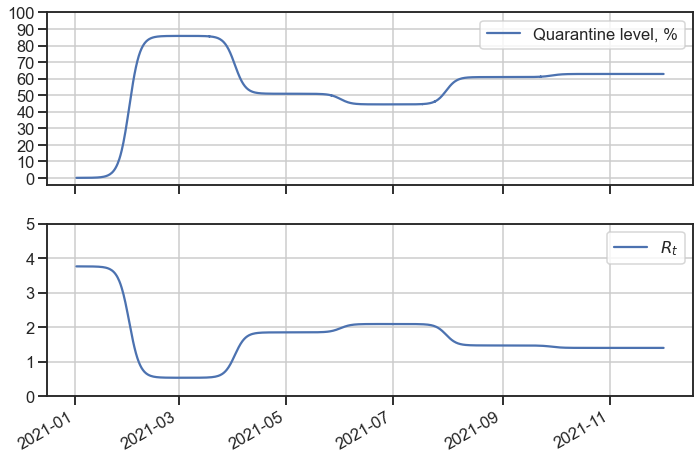

In [18]:
history_dates = df.date.iloc[0] + pd.to_timedelta(history.t, unit='days')

fig = plt.figure(figsize=(10, 7))
ax1 = plt.subplot(2,1,1)
plt.plot(history_dates, history.quarantine_mult, label='Quarantine level, %')
plt.legend()
plt.tight_layout()
y_ticks = list(np.arange(0, 1.1, 0.1).round(1))
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels([f'{int(100*t)}' for t in y_ticks])
plt.grid()

plt.subplot(2,1,2, sharex=ax1)
plt.plot(history_dates, history.rt, label='$R_t$')
plt.ylim(0, 5)
plt.grid()
plt.legend()

fig.autofmt_xdate()
plt.show()

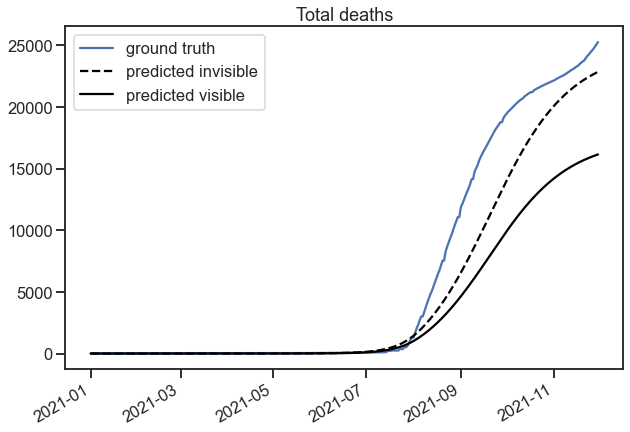

In [19]:
fig = plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted invisible', color='black', linestyle='dashed' )
plt.plot(train_subset.date, Dv, label='predicted visible', color='black')
plt.legend()
plt.title('Total deaths')
fig.autofmt_xdate()
plt.show()

# Evaluate model by cross-validation

In [20]:
from sir_models.utils import eval_on_select_dates_and_k_days_ahead, smape

In [21]:
K = 30
last_day = df.date.iloc[-1] - pd.to_timedelta(K, unit='D')
eval_dates = pd.date_range(start='2021-02-01', end=last_day)[::30]
eval_dates

DatetimeIndex(['2021-02-01', '2021-03-03', '2021-04-02', '2021-05-02',
               '2021-06-01', '2021-07-01', '2021-07-31', '2021-08-30',
               '2021-09-29', '2021-10-29', '2021-11-28', '2021-12-28',
               '2022-01-27', '2022-02-26'],
              dtype='datetime64[ns]', freq='30D')

In [22]:
def eval_hidden_moscow(train_df, t, train_t, eval_t):
    weights = {
        'I': 0.25,
        'R': 0.25,
        'D': 0.5,
    }
    model = SEIRHidden()
    fitter = HiddenCurveFitter(
        new_deaths_col='deaths_per_day_ma7',
        new_cases_col='infected_per_day_ma7',
        new_recoveries_col='recovered_per_day_ma7',
        weights=weights,
        max_iters=1000,
        save_params_every=500)
    fitter.fit(model, train_df)

    train_initial_conditions = model.get_initial_conditions(train_df)
    train_states, history = model.predict(train_t, train_initial_conditions, history=False)

    test_initial_conds = [compartment[-1] for compartment in train_states]
    test_states, history = model.predict(eval_t, test_initial_conds, history=False)
        
    return model, fitter, test_states

In [23]:
models, fitters, model_predictions, train_dfs, test_dfs = eval_on_select_dates_and_k_days_ahead(df,
                                                                                     eval_func=eval_hidden_moscow, 
                                                                                     eval_dates=eval_dates, 
                                                                                     k=K)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   3 out of  14 | elapsed:  2.3min remaining:  8.5min
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:  4.9min remaining:  8.9min
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:  5.1min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:  5.9min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:  6.6min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  7.7min finished


In [25]:
x_dates = [tdf.date.iloc[-1] for tdf in test_dfs]

model_pred_D = [pred[7] for pred in model_predictions]
true_D = [tdf.total_dead.values for tdf in test_dfs]
baseline_pred_D = [[tdf.iloc[-1].total_dead]*K for tdf in train_dfs]

overall_errors_model = [mean_absolute_error(true, pred) for true, pred in zip(true_D, model_pred_D)]
overall_errors_baseline = [mean_absolute_error(true, pred) for true, pred in zip(true_D, baseline_pred_D)]
overall_smape_model = [smape(true, pred) for true, pred in zip(true_D, model_pred_D)]

print('MAE baseline', np.mean(overall_errors_baseline).round(3))
print('MAE model', np.mean(overall_errors_model).round(3))
print('SMAPE model', np.mean(overall_smape_model).round(3))

MAE baseline 1579.193
MAE model 4402.806
SMAPE model 0.332


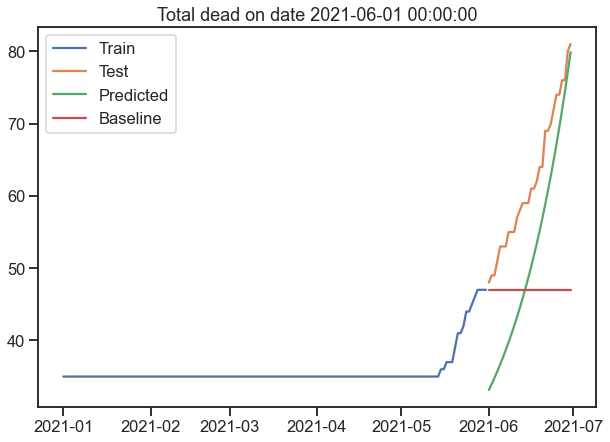

In [26]:
ix = np.random.choice(np.arange(len(train_dfs[-5:])))

train_df = train_dfs[ix]
test_df = test_dfs[ix]
model_preds = model_predictions[ix]
baseline_predictions = baseline_pred_D[ix]
fitter = fitters[ix]
plt.figure(figsize=(10, 7))
plt.plot(train_df.date, train_df.total_dead, label='Train')
plt.plot(test_df.date, test_df.total_dead, label='Test')
plt.plot(test_df.date, model_preds[7], label='Predicted')
plt.plot(test_df.date, baseline_predictions, label='Baseline')
plt.legend()
plt.title(f'Total dead on date {test_df.date.iloc[0]}')
plt.show()

In [28]:
overall_smape_model

[0.6003714866349577,
 0.7536576218217882,
 0.6385495561581881,
 0.4086525239349327,
 0.10131820933530326,
 0.3559723010614009,
 0.6625929226388523,
 0.10968262225984587,
 0.09121135563272359,
 0.2035560534504173,
 0.265201694309195,
 0.15672889013639535,
 0.1461029186354235,
 0.15917741527791493]